# In-Cloud Data Access Clinic (June 2024)

<p></p>

<div style="background:#fc9090;border:1px solid #cccccc;padding:5px 10px;"><big><b>Warning:  </b>Because this notebook uses the S3 protocol, <em><strong>it will only run in an environment with <a href="https://disc.gsfc.nasa.gov/information/glossary?title=AWS%20region">us-west-2 AWS access</a></strong></em>.</big></div>

### Overview

This notebook contains steps for searching, accessing, subsetting, and averaging GPM_3IMERGHH granules using Python and in-cloud methods. It demonstrates how to search for S3 URLs using the python_cmr and earthaccess libraries, opening them with the earthaccess library, and finally, searching and accessing the GPM_3IMERGHH_precipitationCal Zarr store using the S3FS library.

### Prerequisites

This notebook was written using Python 3.9, and requires these libraries and files: 
- netrc file with valid Earthdata Login credentials.
- Xarray
- python_cmr
- earthaccess
- requests
- S3FS
- NumPy

### Other Links:
- [Earthdata Webinar: Analyzing Precipitation Extremes Using Cloud Computing (Zarr)](https://www.earthdata.nasa.gov/learn/webinars-and-tutorials/ges-disc-30-10-2023)
- [`earthaccess` Library How-tos](https://earthaccess.readthedocs.io/en/latest/howto/access-data/)
- [Workshop Slides](https://docs.google.com/presentation/d/129rErCamSIO1bK0A_112pqPmvV82O9Z-a2LJLSRYtIY/edit?usp=sharing)

### 1. Import Modules

In [1]:
import xarray as xr
import s3fs
import earthaccess
import numpy as np
from cmr import VariableQuery
import requests

import warnings
warnings.filterwarnings("ignore")

### 2. Authenticate with `earthaccess`

The `earthaccess` library contains methods to automatically generate the .netrc file required for accessing S3 buckets, if it is not already present, using the `strategy="interactive"` parameter. If the .netrc file does not exist, it will prompt you; if it does exist, or after it is created, it will automatically authenticate your S3 access with a token that will expire in one hour.

In [2]:
auth = earthaccess.login(strategy="interactive", persist=True)

### 3. Search and Access Granules Directly from the S3 Bucket using `earthaccess`

In [3]:
# Search for the data

results = earthaccess.search_data(
    short_name = "GPM_3IMERGHH",
    version = "06",
    cloud_hosted = True,
    temporal = ("2020-02-01", "2020-02-29"),
)

Granules found: 1345


Once granule URLs are found, `earthaccess` will use its `open()` method to automatically format the object storage and authenticate so that we can access it. Then, we can open all the granules using `xr.open_mfdataset()`, while remembering to pass `group=Grid`.

In [4]:
%%time

# Only open one day-this takes quite some time!

files = earthaccess.open(results[:48])

ds = xr.open_mfdataset(files, group="Grid")

ds

Opening 48 granules, approx size: 0.48 GB
using endpoint: https://data.gesdisc.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/48 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/48 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/48 [00:00<?, ?it/s]

CPU times: user 40.4 s, sys: 6.46 s, total: 46.9 s
Wall time: 2min 21s


<xarray.Dataset> Size: 14GB
Dimensions:                         (time: 48, lon: 3600, lat: 1800, nv: 2,
                                     lonv: 2, latv: 2)
Coordinates:
  * time                            (time) object 384B 2020-02-01 00:00:00 .....
  * lon                             (lon) float32 14kB -179.9 -179.9 ... 179.9
  * lat                             (lat) float32 7kB -89.95 -89.85 ... 89.95
Dimensions without coordinates: nv, lonv, latv
Data variables: (12/13)
    time_bnds                       (time, nv) object 768B dask.array<chunksize=(1, 2), meta=np.ndarray>
    lon_bnds                        (time, lon, lonv) float32 1MB dask.array<chunksize=(1, 3600, 2), meta=np.ndarray>
    lat_bnds                        (time, lat, latv) float32 691kB dask.array<chunksize=(1, 1800, 2), meta=np.ndarray>
    precipitationCal                (time, lon, lat) float32 1GB dask.array<chunksize=(1, 145, 1800), meta=np.ndarray>
    precipitationUncal              (time, lon, lat) float32 1GB dask.array<chunksize=(1, 145, 1800), meta=np.ndarray>
    randomError                     (time, lon, lat) float32 1GB dask.array<chunksize=(1, 145, 1800), meta=np.ndarray>
    ...                              ...
    HQprecipSource                  (time, lon, lat) float32 1GB dask.array<chunksize=(1, 291, 1800), meta=np.ndarray>
    HQobservationTime               (time, lon, lat) timedelta64[ns] 2GB dask.array<chunksize=(1, 291, 1800), meta=np.ndarray>
    IRprecipitation                 (time, lon, lat) float32 1GB dask.array<chunksize=(1, 145, 1800), meta=np.ndarray>
    IRkalmanFilterWeight            (time, lon, lat) float32 1GB dask.array<chunksize=(1, 291, 1800), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, lon, lat) float32 1GB dask.array<chunksize=(1, 291, 1800), meta=np.ndarray>
    precipitationQualityIndex       (time, lon, lat) float32 1GB dask.array<chunksize=(1, 145, 1800), meta=np.ndarray>
Attributes:
    GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegistration=CENTER;\nLatitudeRe...

### 4. Subset over Northern California for February 2020

In [5]:
bbox = [-124.295,38.954,-119.989,42.03]
lon_slice = slice(bbox[0], bbox[2])
lat_slice = slice(bbox[1], bbox[3])
year = 2020

start_time = f"{year}-02-01T00:00:00"
end_time = f"{year}-02-29T23:30:00"
time_slice = slice(start_time, end_time)

ds_subset = ds['precipitationCal'].sel(lon=lon_slice, lat=lat_slice, time=time_slice)
ds_subset

<xarray.DataArray 'precipitationCal' (time: 48, lon: 43, lat: 30)> Size: 248kB
dask.array<getitem, shape=(48, 43, 30), dtype=float32, chunksize=(1, 23, 30), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 384B 2020-02-01 00:00:00 ... 2020-02-01 23:30:00
  * lon      (lon) float32 172B -124.2 -124.2 -124.1 ... -120.2 -120.2 -120.1
  * lat      (lat) float32 120B 39.05 39.15 39.25 39.35 ... 41.75 41.85 41.95
Attributes:
    DimensionNames:    time,lon,lat
    Units:             mm/hr
    units:             mm/hr
    CodeMissingValue:  -9999.9

### 5. Calculate Monthly Mean and Plot

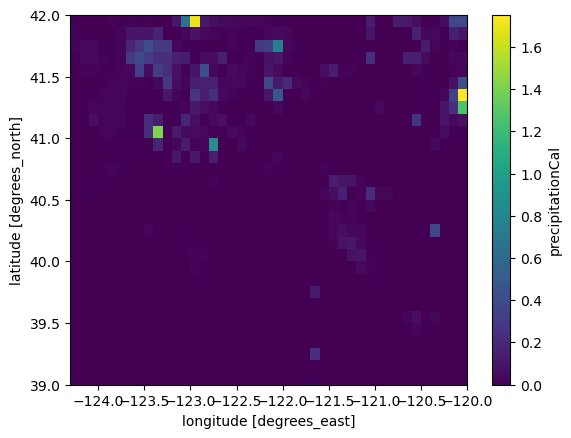

In [6]:
ds_subset.mean(dim='time').plot(x="lon", y="lat")

### 6. Check Direct/External Links

In [7]:
# Download files directly from S3

data_links = [granule.data_links(access="direct") for granule in results[:5]]

data_links

[['s3://gesdisc-cumulus-prod-protected/GPM_L3/GPM_3IMERGHH.06/2020/032/3B-HHR.MS.MRG.3IMERG.20200201-S000000-E002959.0000.V06B.HDF5'],
 ['s3://gesdisc-cumulus-prod-protected/GPM_L3/GPM_3IMERGHH.06/2020/032/3B-HHR.MS.MRG.3IMERG.20200201-S003000-E005959.0030.V06B.HDF5'],
 ['s3://gesdisc-cumulus-prod-protected/GPM_L3/GPM_3IMERGHH.06/2020/032/3B-HHR.MS.MRG.3IMERG.20200201-S010000-E012959.0060.V06B.HDF5'],
 ['s3://gesdisc-cumulus-prod-protected/GPM_L3/GPM_3IMERGHH.06/2020/032/3B-HHR.MS.MRG.3IMERG.20200201-S013000-E015959.0090.V06B.HDF5'],
 ['s3://gesdisc-cumulus-prod-protected/GPM_L3/GPM_3IMERGHH.06/2020/032/3B-HHR.MS.MRG.3IMERG.20200201-S020000-E022959.0120.V06B.HDF5']]

In [8]:
# Download files directly from on-premises HTTPS, or from the cloud, if available

data_links = [granule.data_links(access="external") for granule in results[:5]]

data_links

[['https://data.gesdisc.earthdata.nasa.gov/data/GPM_L3/GPM_3IMERGHH.06/2020/032/3B-HHR.MS.MRG.3IMERG.20200201-S000000-E002959.0000.V06B.HDF5'],
 ['https://data.gesdisc.earthdata.nasa.gov/data/GPM_L3/GPM_3IMERGHH.06/2020/032/3B-HHR.MS.MRG.3IMERG.20200201-S003000-E005959.0030.V06B.HDF5'],
 ['https://data.gesdisc.earthdata.nasa.gov/data/GPM_L3/GPM_3IMERGHH.06/2020/032/3B-HHR.MS.MRG.3IMERG.20200201-S010000-E012959.0060.V06B.HDF5'],
 ['https://data.gesdisc.earthdata.nasa.gov/data/GPM_L3/GPM_3IMERGHH.06/2020/032/3B-HHR.MS.MRG.3IMERG.20200201-S013000-E015959.0090.V06B.HDF5'],
 ['https://data.gesdisc.earthdata.nasa.gov/data/GPM_L3/GPM_3IMERGHH.06/2020/032/3B-HHR.MS.MRG.3IMERG.20200201-S020000-E022959.0120.V06B.HDF5']]

### 7. Access S3 Zarr Store Using `python-cmr` and `Xarray`

Below, we create functions for authentication and opening the Zarr store, which is basically inside of another S3 bucket, and uses a different credential endpoint:

In [9]:
def retrieve_credentials():
    """Makes the Oauth calls to authenticate with EDS and return a set of s3 same-region, read-only credentials."""
    response = requests.get("https://api.giovanni.earthdata.nasa.gov/s3credentials")
    response.raise_for_status()
    return response.json()

def open_zarr_store(bucket_path):
    creds = retrieve_credentials()

    s3 = s3fs.S3FileSystem(key=creds["AccessKeyId"], 
                           secret=creds["SecretAccessKey"], 
                           token=creds["SessionToken"])

    store = s3.get_mapper(bucket_path)
    return store

### 8. Search for Zarr Stores using `python_cmr`

Here, we will use the `python_cmr` library to search for Zarr stores by variable, provider, and collection. Note that we have to manually parse out the collection alongside the variable, as there are multiple collections with `precipitationCal` as a variable.

In [10]:
var = "precipitationCal"
provider = "GES_DISC"
collection = "GPM_3IMERGHH_06"

zarr_stores = [var for var in VariableQuery().provider(provider).get_all() if "instance_information" in var]

for item in zarr_stores:
    if collection in item.get('native_id', ''):
        zarr_store_path = item['instance_information']['url']

zarr_store_path

's3://prod-giovanni-cache/zarr/GPM_3IMERGHH_06_precipitationCal'

### 9. Access Zarr Store using `xarray`

Remember, this is only one variable! You will also notice that it is referred to as `variable`, and not `precipitationCal`.

In [11]:
%%time

ds_zarr = xr.open_zarr(store=open_zarr_store(zarr_store_path), consolidated=False)

# Mask fill values. This is required until this bug is fixed
ds_masked_dropped = ds_zarr.where(ds_zarr["time"] != ds_zarr["time"]._FillValue, drop=True)
ds_masked_dropped

CPU times: user 21 s, sys: 946 ms, total: 22 s
Wall time: 27.7 s


<xarray.Dataset> Size: 10TB
Dimensions:           (latitude: 1800, bounds: 2, time: 374016, longitude: 3600)
Coordinates:
  * latitude          (latitude) float32 7kB -89.95 -89.85 ... 89.85 89.95
  * longitude         (longitude) float32 14kB -179.9 -179.9 ... 179.9 179.9
  * time              (time) datetime64[ns] 3MB 2000-06-01 ... 2021-09-30T23:...
Dimensions without coordinates: bounds
Data variables:
    latitude_bounds   (latitude, bounds, time) float64 11GB dask.array<chunksize=(36, 2, 374016), meta=np.ndarray>
    longitude_bounds  (longitude, bounds, time) float64 22GB dask.array<chunksize=(72, 2, 374016), meta=np.ndarray>
    time_bounds       (time, bounds) datetime64[s] 6MB dask.array<chunksize=(200, 2), meta=np.ndarray>
    variable          (latitude, longitude, time) float32 10TB dask.array<chunksize=(36, 72, 200), meta=np.ndarray>
Attributes:
    Conventions:         CF-1.10
    DOI:                 10.5067/GPM/IMERG/3B-HH/06
    product_long_name:   GPM IMERG Final Precipitation L3 Half Hourly 0.1 deg...
    product_short_name:  GPM_3IMERGHH
    product_version:     06

### 10. Subset over Northern California in February 2020

Note that the latitude and longitude coordinates are now "latitude" and "longitude", instead of "lat" and "lon".

In [12]:
bbox = [-124.295,38.954,-119.989,42.03]
lon_slice = slice(bbox[0], bbox[2])
lat_slice = slice(bbox[1], bbox[3])
year = 2020

start_time = f"{year}-02-01T00:00:00"
end_time = f"{year}-02-28T23:30:00" if year % 4 != 0 else f"{year}-02-29T23:30:00" # Handling leap years
time_slice = slice(start_time, end_time)

ds_subset = ds_masked_dropped.sel(longitude=lon_slice, latitude=lat_slice, time=time_slice)
ds_subset

<xarray.Dataset> Size: 9MB
Dimensions:           (latitude: 30, bounds: 2, time: 1392, longitude: 43)
Coordinates:
  * latitude          (latitude) float32 120B 39.05 39.15 39.25 ... 41.85 41.95
  * longitude         (longitude) float32 172B -124.2 -124.2 ... -120.2 -120.1
  * time              (time) datetime64[ns] 11kB 2020-02-01 ... 2020-02-29T23...
Dimensions without coordinates: bounds
Data variables:
    latitude_bounds   (latitude, bounds, time) float64 668kB dask.array<chunksize=(6, 2, 1392), meta=np.ndarray>
    longitude_bounds  (longitude, bounds, time) float64 958kB dask.array<chunksize=(19, 2, 1392), meta=np.ndarray>
    time_bounds       (time, bounds) datetime64[s] 22kB dask.array<chunksize=(168, 2), meta=np.ndarray>
    variable          (latitude, longitude, time) float32 7MB dask.array<chunksize=(6, 19, 168), meta=np.ndarray>
Attributes:
    Conventions:         CF-1.10
    DOI:                 10.5067/GPM/IMERG/3B-HH/06
    product_long_name:   GPM IMERG Final Precipitation L3 Half Hourly 0.1 deg...
    product_short_name:  GPM_3IMERGHH
    product_version:     06

Next, calculate the mean, and plot in a much faster duration!

CPU times: user 14.8 s, sys: 1.25 s, total: 16.1 s
Wall time: 16.5 s


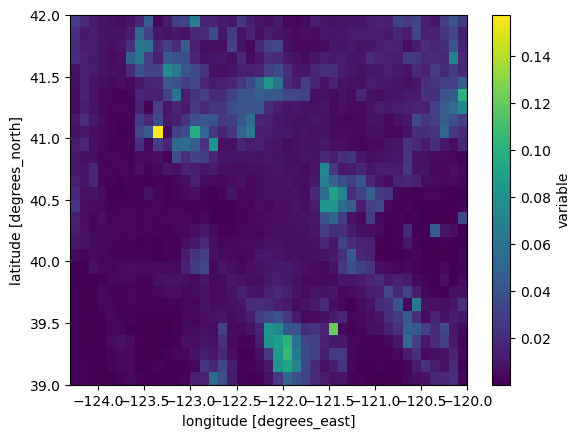

In [13]:
%%time
ds_subset['variable'].mean(dim='time').plot()